In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

Code for the model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data
file_path = 'total_expenses.csv'
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the last 6 months
six_months_ago = df['Date'].max() - pd.DateOffset(months=6)
df_filtered = df[df['Date'] >= six_months_ago]

# Sort by date if necessary
df_filtered = df_filtered.sort_values(by='Date')

# Extract the 'Amount' column or other columns as needed
data = df_filtered[['Amount']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
    return np.array(X)

seq_length = 7  # History sequence
X = create_sequences(scaled_data, seq_length)

# Split data into training and testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, X_train, epochs=50, verbose=1)

all_data = list(data.flatten())
all_predictions = [None] * len(all_data)
all_min_predictions = [None] * len(all_data)
all_max_predictions = [None] * len(all_data)
new_data_feeded=[]
new_predicted_data=[]

plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(figsize=(12, 6))


def calculate_min_max_with_error(prediction, error_std,actual ,predicted):
    """Returns a tuple with min and max predictions based on error standard deviation."""
    adjusted_error = error_std * np.where(actual > predicted, 1.5, 0.5)
    min_pred = prediction - 1.96 * adjusted_error
    max_pred = prediction + 1.96 * adjusted_error
    return min_pred, max_pred

def calculate_accuracy(actual_values, predicted_values):
    """Calculate accuracy of predictions based on actual values."""
    actual = np.array(actual_values)
    predicted = np.array(predicted_values)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(actual - predicted))

    return mape, mae

scaled_data_with_input = scaler.transform(np.array(all_data).reshape(-1, 1))
new_seq = scaled_data_with_input[-seq_length:]
new_seq = new_seq.reshape((1, seq_length, 1))

# Make prediction for the next day
new_prediction = model.predict(new_seq).flatten()
new_prediction_inv = scaler.inverse_transform(new_prediction.reshape(-1, 1)).flatten()

# Calculate min and max predictions


# Update the last element in `all_predictions`, `all_min_predictions`, `all_max_predictions`
all_predictions[len(all_data) - 1] = new_prediction_inv[0]
all_min_predictions[len(all_data) - 1] = None
all_max_predictions[len(all_data) - 1] = None

all_predictions.append(None)
all_min_predictions.append(None)
all_max_predictions.append(None)

scaled_data_with_input = scaler.transform(np.array(all_data).reshape(-1, 1))

# Update the sequence with new data and predict the next 1 day
new_seq = scaled_data_with_input[-seq_length:]
new_seq = new_seq.reshape((1, seq_length, 1))

# Make prediction for the next day
new_prediction = model.predict(new_seq).flatten()
new_prediction_inv = scaler.inverse_transform(new_prediction.reshape(-1, 1)).flatten()

new_predicted_data.append(new_prediction_inv[0])

# Update predictions
all_predictions[len(all_predictions) - 1] = new_prediction_inv[0]
all_min_predictions[len(all_predictions) - 1] = None
all_max_predictions[len(all_predictions) - 1] = None
all_min_predictions = np.array(all_min_predictions, dtype=np.float64)
all_max_predictions = np.array(all_max_predictions, dtype=np.float64)


# Clear the previous graph
ax.clear()

# Plot the actual expenditures
ax.plot(np.arange(len(all_data)), all_data, label='Actual Spending', color='blue')

# Plot the predicted spending
ax.plot(np.arange(len(all_predictions)), all_predictions, label='Predicted Spending', color='red')

# Plot the min and max predictions as bands
# ax.fill_between(np.arange(len(all_predictions)), all_min_predictions, all_max_predictions ,
#                 color='orange', alpha=0.3, label='Prediction Range (Min-Max)')

ax.set_xlabel('Day of the Month')
ax.set_ylabel('Expenditure (₹)')
ax.set_title('Daily Expenditure with 1-Day LSTM Prediction and Range')
ax.legend()
ax.grid(True)

# Redraw the updated plot
fig.canvas.draw()
fig.canvas.flush_events()

all_min_predictions = np.array(all_min_predictions, dtype=np.float64).tolist()
all_max_predictions = np.array(all_max_predictions, dtype=np.float64).tolist()

# Function to update graph based on new inputs
def update_graph(new_data):
    global all_predictions, all_min_predictions, all_max_predictions,new_data_feeded,new_predicted_data,budget,i,avg
    # old_predictions=[]

    budget=budget-new_data
    if i>=30:
            present_day_avg=budget
    else:
            present_day_avg=budget/(30-i)



    new_data_feeded.append(float(new_data))

    # Calculate errors between actual and predicted values (after the look-back period)
    errors = np.abs(np.array(new_data_feeded[:]) - np.array(new_predicted_data[:]))

    # Compute the standard deviation of the errors (this helps assess the spread of the predictions)
    error_std = np.std(errors)

    # Update the actual data with new input
    all_data.append(new_data)

    # Expand the all_predictions, all_min_predictions, and all_max_predictions lists
    all_predictions.append(None)
    all_min_predictions.append(None)
    all_max_predictions.append(None)
    # old_predictions.append(None)

    scaled_data_with_input = scaler.transform(np.array(all_data).reshape(-1, 1))

    # Update the sequence with new data and predict the next 1 day
    new_seq = scaled_data_with_input[-seq_length:]
    new_seq = new_seq.reshape((1, seq_length, 1))

    # Make prediction for the next day
    new_prediction = model.predict(new_seq).flatten()
    new_prediction_inv = scaler.inverse_transform(new_prediction.reshape(-1, 1)).flatten()

    print("presnt day average:",present_day_avg)
    # old_predicted_data=new_prediction_inv[0]
    print("Original Prediction:",new_prediction_inv[0])

    percentage=None
    # if new_limit>=avg:
    #     if ((present_day_avg-new_limit)/avg)*100<(-100) and ((present_day_avg-new_limit)/avg)*100>=(-220):
    #         print("Actual Percentage:",((present_day_avg-new_prediction_inv[0])/present_day_avg)*100)
    #         percentage=100+(((present_day_avg-new_prediction_inv[0])/present_day_avg)*100)
    #         # percentage=percentage*-1
    #         print("hi")
    #         new_prediction_inv[0]=new_prediction_inv[0]*((percentage)/100)

    #     elif ((present_day_avg-new_limit)/avg)*100<(-220) and ((present_day_avg-new_limit)/avg)*100>(-300):
    #         percentage=100+(((present_day_avg-new_prediction_inv[0])/present_day_avg)*100)
    #         new_prediction_inv[0]=new_prediction_inv[0]*(100+(percentage)/100)
    #     elif ((present_day_avg-new_limit)/avg)*100<(-300):
    #         new_prediction_inv[0]=present_day_avg*.8

    #     else:
    #         percentage=((present_day_avg-new_limit)/avg)*100
    #         percentage=percentage*-1
    #         print("Aman",((present_day_avg-new_limit)/avg)*100)
    #         new_prediction_inv[0]=new_prediction_inv[0]*((100+(percentage))/100)
    # else:
    #     if ((present_day_avg-avg)/avg)*100<30 and ((present_day_avg-avg)/avg)*100>=0:
    #         print("Hello 1")
    #         percentage=((present_day_avg-avg)/avg)*100
    #         new_prediction_inv[0]=new_prediction_inv[0]*((100+(percentage))/100)
    #     else:
    #         print("Hello 2")
    #         percentage=100-(((new_prediction_inv[0]-avg)/present_day_avg)*100)
    #         new_prediction_inv[0]=new_prediction_inv[0]*((100+(percentage))/100)

    ideal_avg=1/30*i
    if new_limit>=present_day_avg and (present_day_avg/new_prediction_inv[0]<0.8 or new_prediction_inv[0]/present_day_avg<0.8):
        actual_avg=budget/3000
        if (ideal_avg/actual_avg)>=0.5:
            decrement=1-(ideal_avg/actual_avg)
        else:
            decrement=0.5-(ideal_avg/actual_avg)
        new_prediction_inv[0]=new_prediction_inv[0]*decrement
        if new_prediction_inv[0]<=5:
            new_prediction_inv[0]=present_day_avg*0.8
    elif new_limit>=present_day_avg and (present_day_avg/new_prediction_inv[0]>0.8 or new_prediction_inv[0]/present_day_avg>0.8):
        if present_day_avg>new_prediction_inv[0]:
            new_prediction_inv[0]=new_prediction_inv[0]*1.08
        else:
            new_prediction_inv[0]=new_prediction_inv[0]*0.92
    else:
        actual_avg=budget/3000
        if ideal_avg<actual_avg:
            if new_prediction_inv[0]>new_limit*0.3 and new_prediction_inv[0]<new_limit*1.4:
                incremenet=1+(ideal_avg/actual_avg)
            else:
                if new_limit<present_day_avg and new_limit<new_prediction_inv[0]*0.7 :
                    print("hii")
                    if ideal_avg/actual_avg<0.5:
                        incremenet=1+(ideal_avg/actual_avg)
                    else :
                        incremenet=0.5+(ideal_avg/actual_avg)
                else:
                    print("Hello")
                    incremenet=1-(ideal_avg/actual_avg)
        else:
            print("Hello2")
            incremenet=0.6+(actual_avg/ideal_avg)

        new_prediction_inv[0]=new_prediction_inv[0]*incremenet

    print("Percentage:",percentage)

    # new_prediction_inv[0]=new_prediction_inv[0]*((100+(percentage))/100)
    print( "calculated Prediction :",new_prediction_inv[0])

    # Calculate min and max predictions
    # old_predictions.append(old_predicted_data)
    prediction=new_prediction_inv[0]
    if new_data>=2.5*(all_predictions[len(all_predictions) - 2]):
        min_pred, max_pred = calculate_min_max_with_error(present_day_avg,error_std,new_data_feeded[0],new_predicted_data[0])
    else:
        min_pred, max_pred = calculate_min_max_with_error(prediction,error_std,new_data_feeded[0],new_predicted_data[0])

    mape, mae = calculate_accuracy(new_data_feeded, new_predicted_data)
    print(f'MAPE: {100-mape:.2f}%, MAE: {mae:.2f}₹')
    new_predicted_data.append(new_prediction_inv[0])
    # Update predictions
    all_predictions[len(all_predictions) - 1] = new_prediction_inv[0]
    all_min_predictions[len(all_predictions) - 1] = min_pred
    all_max_predictions[len(all_predictions) - 1] = max_pred
    all_min_predictions = np.array(all_min_predictions, dtype=np.float64)
    all_max_predictions = np.array(all_max_predictions, dtype=np.float64)


    print()
    # Clear the previous graph
    ax.clear()

    # Plot the actual expenditures
    ax.plot(np.arange(len(all_data)), all_data, label='Actual Spending', color='blue')

    # Plot the predicted spending
    ax.plot(np.arange(len(all_predictions)), all_predictions, label='Suggeseted Spending', color='red')
    # ax.plot(np.arange(len(all_predictions)), old_predicted_data, label='Predicted Spending', color='gree/n')

    # Plot the min and max predictions as bands
    ax.fill_between(np.arange(len(all_predictions)), all_min_predictions, all_max_predictions ,
                    color='orange', alpha=0.3, label='Prediction Range (Min-Max)')

    # ax.text(1, 13, f'Accuracy: {100-mape:.2f}%', fontsize=12, color='black',
    #     bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))


    ax.set_xlabel('Day Of Month')
    ax.set_ylabel('Expenditure (₹)')
    ax.set_title(f'Daily Expenditure with 1-Day LSTM Prediction and Range    ')
    ax.legend()
    ax.grid(True)

    # Redraw the updated plot
    fig.canvas.draw()
    fig.canvas.flush_events()


    all_min_predictions = np.array(all_min_predictions, dtype=np.float64).tolist()
    all_max_predictions = np.array(all_max_predictions, dtype=np.float64).tolist()

    return prediction



# Loop to take real-time input and update the graph

bfile_path = 'Weekly_limit.csv'
i=1# Update this path to your actual CSV file path
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the date 6 months ago from the latest date in the dataset
six_months_ago = df['Date'].max() - pd.DateOffset(months=6)

# Filter the DataFrame to get data after the 6-month mark
df_filtered = df[df['Date'] >= six_months_ago]

# Check if there are enough days to feed into the loop
if df_filtered.shape[0] < 30:
    print("Not enough data for the next 30 days after skipping 6 months.")
else:
    current_month = None  # Initialize a variable to keep track of the current month

    for index, row in df_filtered.iterrows():
        # Get the date and amount from the filtered DataFrame
        date = row['Date']
        new_limit=row['Amount']
        # new_limit =float(input())

        # Check if it's a new month and prompt for a new budget if it is
        if current_month != date.month:
            current_month = date.month
            # Prompt for the new budget at the start of the month
            budget = float(input(f"\nNew Month: {date.strftime('%B %Y')}. Enter the budget (₹): "))
            avg = budget / 30  # Reset average budget for the new month
            print(f"Budget set to ₹{budget:.2f} with daily average of ₹{avg:.2f}.")

        # Here you could call your update_graph function (which you need to define)
        update_graph(new_limit)  # Replace this with your actual function call
        if i>30:
            i=1
        else:
            i=i+1
        print(i)

        print(f"Date: {date.strftime('%Y-%m-%d')}, Daily Expenditure Limit set to ₹{new_limit:.2f}")


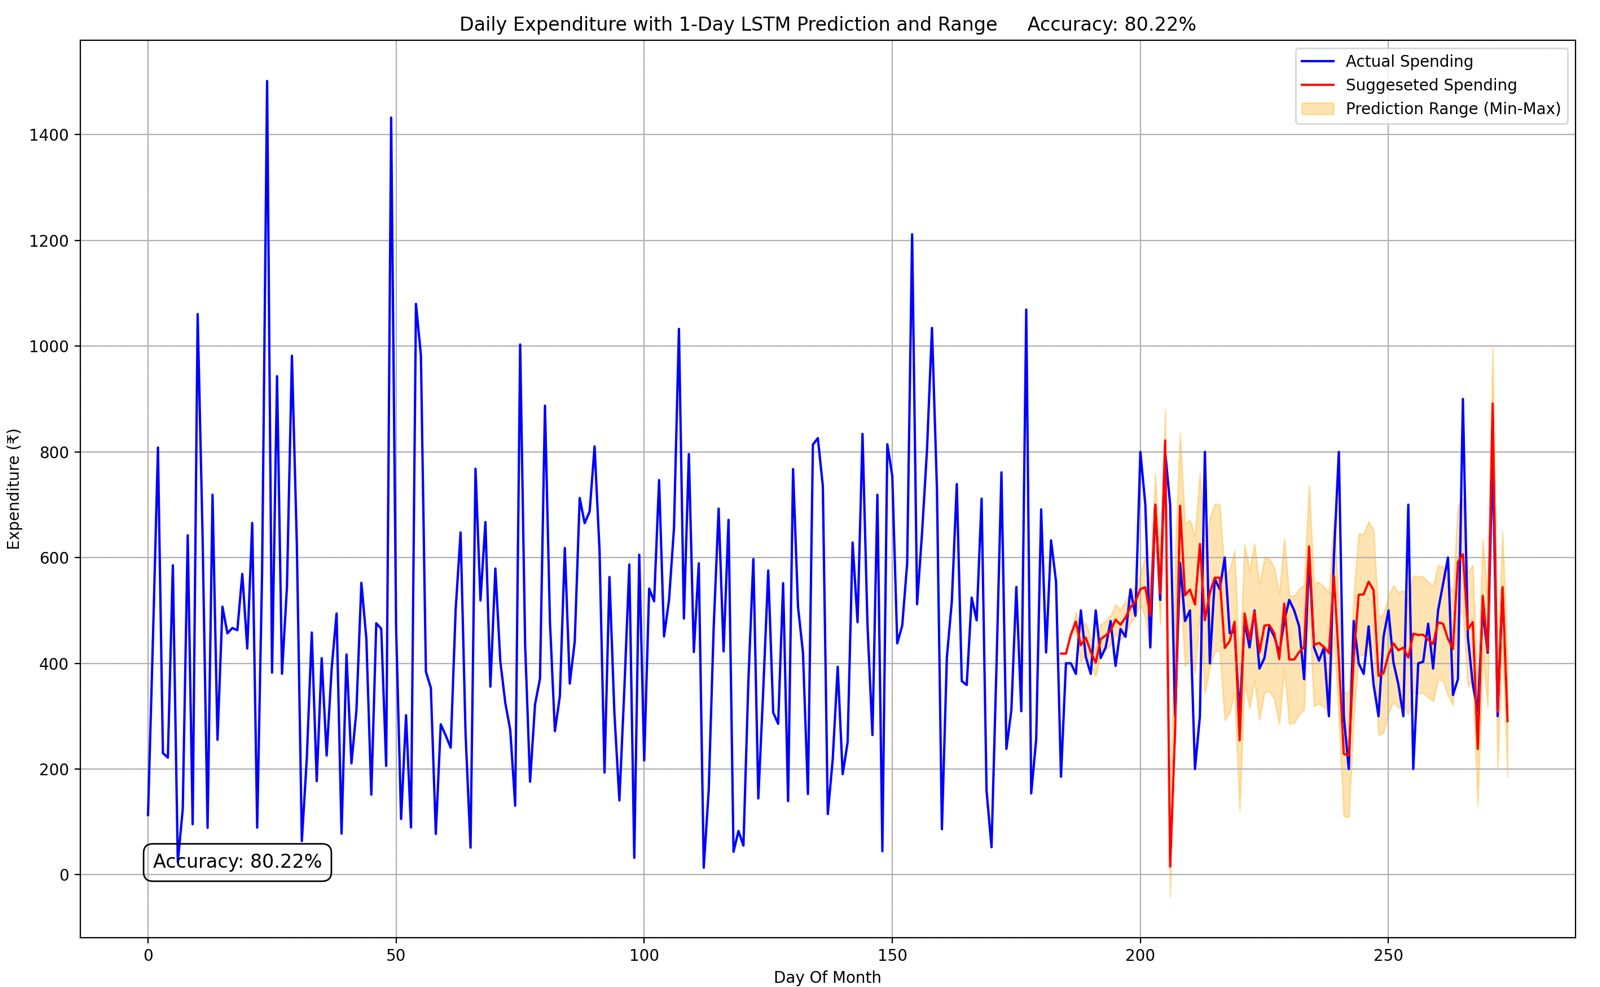

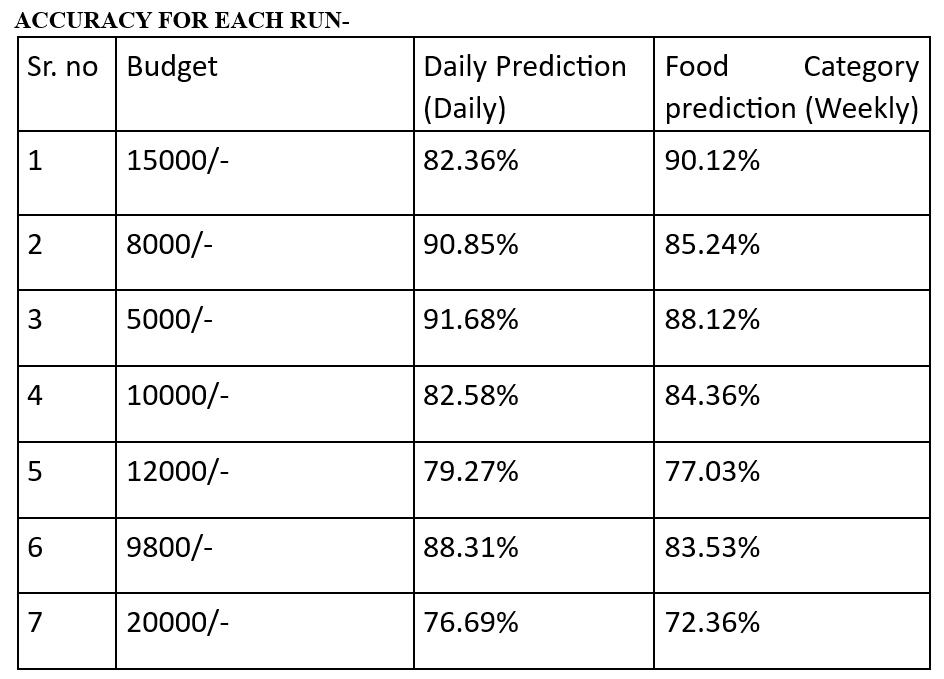
